## Mini-Projet: Séparation de sources hyperspectrale

Une image hyperspectrale est une image où un spectre contenant $D$ valeurs ou canaux est enregistré à chaque pixel. Cette modalité d'imagerie est très utilisée en imagerie satellitaire, où elle permet d'améliorer considérablement la résolution de la prise d'image. Dans le cas des images satellitaires, les pixels de l'image ont ainsi une résolution spatiale de l'ordre de la dizaine de mètres, de sorte que ces pixels mélangent les contributions des différents éléments présents sur la scène imagée (végétation, eau, minéraux du sol, habitations, routes, etc.). Nous nous intéressons ici à un problème, connu sous le nom de séparation de sources hyperspectrale, qui vise à identifier, pour une observation donnée, les spectres des constituants élémentaires présents dans une scène, ainsi que la proportion ("l'abondance") de ces constituants en chaque pixel de l'image.

L'objectif de ce mini-projet est d'implémenter un algorithme de séparation de source hyperspectral et de l'appliquer à une image satellitaire issue de la base de donnée SAMSON. L'image en question est de taille 95 x 95 pixels. Chaque pixel correspond à un spectre de 156 canaux, qui couvrent un intervalle de longueurs d'onde qui s'étend de 401 à 889 nm. La résolution spectrale est de 3.13 nm. Chaque spectre Y(x, y) mesuré au niveau du pixel (x, y) de l'image correspond à la combinaison linéaire des spectres *élémentaires* associés à l'eau, à la végétation et aux minéraux présents dans le sol:

$$
Y[x, y] = \alpha_{1} [x, y] m_1 + \alpha_2 [x, y] m_2 + (1 - \alpha_1[x, y] - \alpha_2[x, y]) m_3,
$$

où $\alpha_1[x, y]$ et $\alpha_2[x, y]$ correspondent aux proportions relatives d'eau et de végétation en surface à la position $[x, y]$, et $m_1$, $m_2$ et $m_3$ correspondent aux spectres élémentaires de l'eau, de la végétation et du sol minéral respectivement.



In [15]:
# -*- Encoding: Latin-1 -*-
#!/usr/bin/python

from math import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from math import factorial
from scipy.linalg import eigh, det, norm

from threading import Thread # Librairie de multithreading  (rapidité calcul final)
import time # Mesure du temps d'éxécution

In [16]:
data_dict = loadmat("Samson.mat")
a = data_dict['A'].reshape((95*95, 3))
end = data_dict['M']
data = np.dot(a, end.T)

## 1. Visualisation des données

Le script ci-dessous permet de charger les données de l'image. Implémenter une fonction python permettant de visualiser:
- le spectre mesuré en un pixel de l'image
- l'image obtenue à une longueur d'onde donnée

In [17]:
def display_spectrum(img, loc):
    
    """
    Display the spectrum at location (x, y)
    
    :param img: Hyperspectral image
    :type img: 3D numpy array
    :param loc: Pixel location
    :type loc: tuple
    
    """
    liste_lambda = np.arange(401, 889, 3.13) # Bande de fréquence analysée
    liste_intensite = img[loc[0], loc[1]] # Extraction intensités par fréquence en un pixel
    plt.figure("Local spectrum", figsize = (9, 5))
    plt.title("Local spectrum")
    plt.ylabel("Radiance")
    plt.plot(liste_lambda, liste_intensite)
    plt.show()

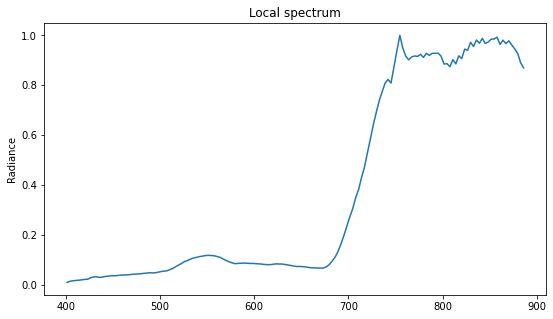

In [18]:
display_spectrum(data.reshape((95, 95, 156)), (50, 50))

On observe ici le spectre en un pixel. Ainsi, on peut remarquer que ce pixel émet plus vers $800 nm$ c'est-à-dire vers le rouge. En tant qu'humain nous pourrions affirmer qu'il s'agit donc majoritairement d'un sol minéral. Mais l'idée du projet consiste à décomposer automatiquement chaque pixel en proportion de sol, d'eau et de végétation.

In [19]:
def display_band(img, spectr_idx):
    
    """
    Display the image corresponding to the specified spectral band
    
    :param img: Hyperspectral image
    :type img: 3D numpy array
    :param spectr_idx: Indexof the spectral band to display
    :type loc: int
    
    """
    img_filtre = img[:,:,spectr_idx] # Extraction de l'intensité en une longueur d'onde pour tous les pixels
    plt.figure("Special band image", figsize = (6,6))
    plt.title("Special band image")
    plt.gca().pcolormesh(img_filtre) # Affichage en pseudo-couleurs
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

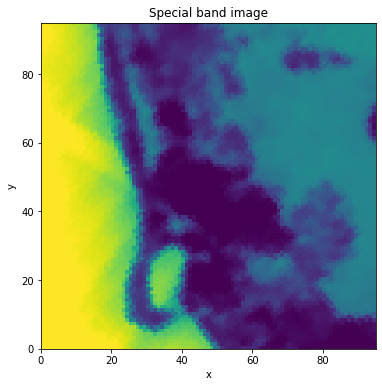

In [20]:
display_band(data.reshape((95, 95, 156)), 10)

Sur l'image complète on remarque qu'il y a des inhomogénéité de l'intensité d'émission pour une certaine longueur d'onde. Cela justifie le fait qu'il existe plusieurs "types" de zones et qu'il faut donc décomposer chaque pixel. Cependant, il faut prendre en compte toutes les fréquences d'émission contrairement à cette image qui n'en regarde qu'une.

## 2. Réduction de dimension

Les spectres observés dans les données sont des vecteurs de dimension $D = 156$ et peuvent donc être représentés dans l'espace vectoriel $\mathbb{R}^D$. Ces spectres correspondent cependant à la combinaison linéaire de $K = 3$ spectres élémentaires, pondérés par les quantités positives $\alpha _1$, $\alpha_2$ et $\alpha_3$, qui correspondent à la proportion relative de chacun des spectres élémentaires. Par ailleurs, on a la relation de liaison supplémentaire:

$$
\alpha_1 + \alpha_2 + \alpha_3 = 1.
$$

Compte tenu de ces différentes relations, est-il possible de réduire la dimension des données, c'est à dire de déterminer un sous-espace de $\mathbb{R}^D$ qui contienne l'ensemble des points de données ? Quelle serait la dimension de cet espace ? En utilisant l'algorithme d'analyse en composantes principales (ACP, ou PCA en anglais) présenté dans les slides accompagnant le mini-projet, identifier le sous-espace en question. Projeter les données spectrales dans ce sous-espace, et afficher le résultat. Commenter le résultat. En particulier, comment explique-t-on la distribution géométrique des données spectrales?


In [21]:
def pca(data, K):

    """
    Principal component analysis (PCA)
    """
    # Calcul de la matrice de covariance et de sa moyenne
    cov = np.cov(data.T)
    mean = np.mean(data)

    # Calcul des vecteurs et valeurs propres de la matrice de covariance
    eival, eivec = eigh(cov)

    # Extraction des K vecteurs propres associés aux plus grandes valeurs propres
    eival_max = eival[-K:]
    eivec_max = eivec[:, -K:]
    
    # Projection des données sur l'espace engendré par les K vecteurs propres choisis
    Y = data - mean
    Y = Y @ eivec_max

    return Y

In [22]:
projected_data = pca(data, 2) # Application à notre image

# 3. Détermination des spectres élémentaires

Dans l'espace de dimension réduite déterminé dans la question précédente, les données spectrales prennent la forme géométrique d'un simplexe. Les sommets de ce simplexe correspondent aux spectres élémentaires présents dans la scène. Implémenter l'algorithme N-FINDR décrit dans les slides accompagnant le mini-projet pour déterminer les spectres élémentaires.



In [23]:
class nfindr:

    """
    NFINDR algorithm implementation
    """

    def __init__(self, projected_data, R):

        """
        Constructor

        :param projected_data: Projected data points
        :param R: Number of endmembers
        :type projected_data: Numpy array 
        :type R: int
        """

        self.projected_data = projected_data
        self.N, self.K = self.projected_data.shape    
        self.R = R 


    def set_endmembers(self):

        """
        Initialize the NFINDR algorithm 
        """

        # Sélection aléatoire de K vecteurs de la base de données
        rand_index = [np.random.randint(0, 9025) for k in range(self.R)]
        self.indexs = rand_index
        self.endmembers = self.projected_data[rand_index, :]

        # Calcul Volume du simplex
        first_point = self.endmembers[0, :]
        M = self.endmembers - first_point
        M = M[1:]
        self.V = np.abs(np.linalg.det(M))/factorial(self.R) # Application formule

        

    def iterate(self):

        """
        N-FINDR Iteration
        """

        # Itération sur les sommets du simplex
        for p in range(self.R):
            end = np.copy(self.endmembers)

            # Itération sur les points de la base de données
            for q in range(self.N):
                
                # Remplacement du sommet actuel par un point de la base de données
                end[p,:] = self.projected_data[q, :]

                # Actualisation du simplex si nouveau volume supérieur
                first_point = end[0, :]
                M = end - first_point
                M = M[1:]
                new_V = np.abs(np.linalg.det(M))/factorial(self.R)
                
                if new_V > self.V:
                    self.endmembers[p] = end[p]
                    self.V = new_V
                    self.indexs[p] = q



    def run(self):

        """
        Run the algorithm
        """

        # Sélection aléatoire des sommets du simplex dans la base de données
        self.set_endmembers()

        # Itération jusqu'à idempotence
        flag = True
        while flag:
            end_cond = self.endmembers
            self.iterate()
            if np.array_equal(self.endmembers, end_cond):
                flag = False
  
        # Affichage résultat
        self.display_endmembers()
        self.original = data[self.indexs]
            

    def display_endmembers(self):

        """
        Scatter plot of the simplex data
        """
        #print(self.endmembers)
        plt.figure("Simplex data", figsize = (9, 6))
        plt.scatter(self.endmembers[:,0], self.endmembers[:,1])
        plt.scatter(projected_data[:,0], projected_data[:, 1], s=1)
        plt.title("Simplex data")
        plt.show()
        



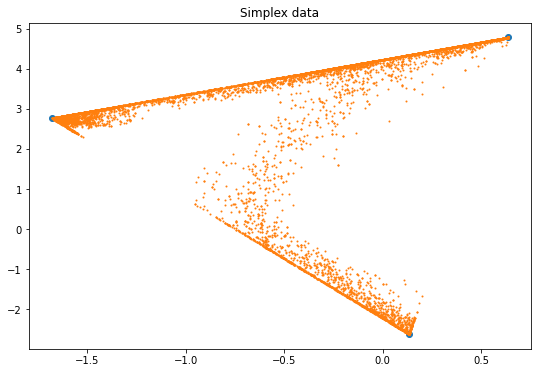

In [24]:
inst = nfindr(projected_data, R=3)
inst.run()

# 4. Détermination des abondances

Nous cherchons maintenant à identifier les abondances de chacun des spectres, c'est à dire à déterminer, en chaque point, quelle est la proportion relative de chacun des spectres élémentaires identifiés dans l'étape précédente. Pour ce faire, nous cherchons à résoudre, à chaque pixel de l'image, le problème d'optimisation suivant:

$$
\alpha := \arg \min \| Y[x, y] - \sum_{i = 1}^3 \alpha _{i}[x, y] m_i \|^2
$$

sous les contraintes 

$$
\forall i = 1,2,3, \quad \alpha_i \geq 0
$$

et 

$$
\sum_{i = 1}^3 \alpha_i = 1.
$$

Pour résoudre ce problème, appliquer un algorithme de descente de gradient projeté, tel que décrit dans les slides.

In [25]:
class projected_gradient:

    """
    Projected gradient descent implementation for solving
    minimize ||Ma - y||^2 s.t 0 <= a <= 1.
    """

    def __init__(self, M, y):

        """
        Constructor
        
        :param M: endmembers matrix
        :param y: spectra
        """
        
        self.M = M.T
        ones = np.ones(shape=(1, 3)) # Ajout de la ligne de 1
        self.M = np.concatenate((self.M, ones))
        
        self.D, self.R = self.M.shape
        
        self.y = y
        self.y = np.append(self.y, 1.) # Ajout 1 dans la colonne
        
        self.a = np.array([0., 0., 0.]) # Point d'initialisation       
        self.f = lambda a : norm(self.M @ a - self.y, ord = 2) # Fonction coût
        self.grad_J = lambda a : 2*np.dot(self.M.T, self.M @ a - self.y) # Gradient fonction coût
        
        self.alpha = 0.001 # Coefficient pour condition d'Armijo
        self.beta = 0.25 # Coefficient de recherche de pas

    def iterate(self):

        """
        Iteration of the projected gradient descent algorithm
        """
        
        next = True
        t = 1 # Pas initial
        tol = 0.01 # Tolérance pour égalité condition Armijo
        
        # Recherche de pas otpimal
        while(next):
            
            a_copy = self.a.copy()
            
            # Calcul membre de droite
            droite = self.f(a_copy) - self.alpha*t*np.linalg.norm(self.grad_J(a_copy))**2
            
            # Application pas
            a_copy -= t*self.grad_J(a_copy)
            
            # Calcul membre de gauche
            gauche = self.f(a_copy)            
            
            # Vérification condition d'Armijo
            if  (gauche - droite <= tol):
                next = False
            else:
                # Modification pas
                t *= self.beta
                
        self.a = a_copy
        

        #self.a -= t*grad_J

        # Projection sur l'espace valide
        self.a[self.a < 0] = 0.
        self.a[self.a > 1] = 1.
        
        #print("a : ", self.a, " -> somme = ", sum(self.a))
        #print(np.linalg.norm(self.grad_J(self.a)))
                

    def run(self, eps, maxiter):

        """
        Run the proximal gradient algorithm

        :param eps: Requested precision 
        :param maxiter: Maximal number of iteration
        """
        iter = 0
        while iter < maxiter:
            self.iterate()
            iter += 1
            
            # Vérification condition d'arrêt (nullité gradient)
            if np.linalg.norm(self.grad_J(self.a)) <= eps:
                #print(np.linalg.norm(self.grad_J(self.a)))
                return self.a

In [26]:
# Test
test = projected_gradient(inst.original, data[9024, :])
rep = test.run(0.1, 10000)
print("résultat : ", rep, " -> somme = ", sum(rep))

résultat :  [0.06565226 0.01500216 0.92441931]  -> somme =  1.0050737254981201


In [27]:
def abundances_thread(t_id, abundances, shape):
    
    """
    Computes the abundances for each pixel of its work line (defnined by t_id). This is a
    calcul unit.
    
    :param t_id: Thread id (work line)
    :param abundances : Abundances map
    :param shape: Shape of the Abundances map
    
    :type t_id: Integer
    :type abundances: Numpy Array
    :type shape: Integer Tuple
    """
    
    # Pour chaque colonne de sa ligne
    for j in range(shape[1]):
                       
        pix = data[t_id*shape[0] + j, :]
        proj = projected_gradient(inst.original, pix)
        ab_pix = proj.run(0.1, 100)
        abundances[t_id, j, :] = ab_pix
        
        
        if t_id==0:
            print(t_id, j)
        
        
    print(f"Thread n°{t_id} fini !")


def display_abundances(abundances):

    """
    Display the abundances maps

    :param abundances: Abundances map
    :type abunbances: Numpy array
    """
    shape = abundances.shape
    
    # Utilisation de multithreading pour accélérer le calcul
    threads = [ Thread( target=abundances_thread, args=(t_id, abundances, shape)) for t_id in range(shape[0])]
    
    # Lancement des threads
    print("Lancement calculs")
    for t in threads:
        t.start()
    
    # Attente de la fin des threads
    for t in threads:
        t.join()
    print("Fin calculs")
    
    # Affichage
    plt.figure("Abundances map", figsize = (6,6))
    plt.title("Abundances map")
    plt.imshow(abundances)


Lancement calculs
0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
Thread n°25 fini !
Thread n°21 fini !
0 69
Thread n°19 fini !
0 70
0 71
0Thread n°22 fini !
 72
Thread n°10 fini !
Thread n°1 fini !0
 73
Thread n°81 fini !
Thread n°9 fini !
Thread n°72 fini !
0 74
Thread n°26 fini !
Thread n°20 fini !
Thread n°3 fini !
Thread n°18 fini !
0 75
Thread n°15 fini !
Thread n°2 fini !
Thread n°27 fini !Thread n°70 fini !

0Thread n°73 fini !
 76
Thread n°24 fini !
Thread n°28 fini !
Thread n°16 fini !
Thread n°7 fini !
0 77
Thread n°6 fini !
Thread n°8 fini !
0 78
Thread n°23 fini !
Thread n°54 fini !
Thread n°61 fini !
Thread n°14 fini !Thread n°50 fini !

0Thread n°77 fini !
 79
0Thread n°5 fini !
 Thread n°

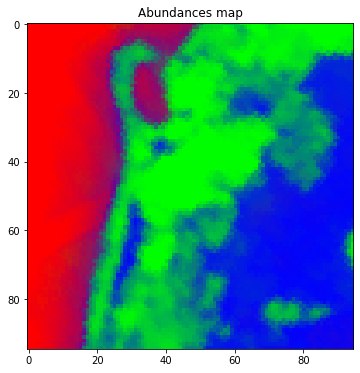

In [28]:
### Estimation des abondances ###

endmembers = inst.endmembers
N, D = projected_data.shape

R = D + 1 # Nombre de sommets du simplex
abundances = np.zeros((N, R))
    
# L'astuce pour la contrainte de somme égale à un est prise en compte dans les attributs de la classe

start_time = time.time()
display_abundances(abundances.reshape((95, 95, 3)))
end_time = time.time()
print(f"Temps d'éxécution : {end_time - start_time / 60} minutes")

On observe ici la carte des abondances issue de l'image hyperspectrale initiale. On distingue bien plusieurs zones de couleurs : le rouge pour le sol minéral, le vert pour la végétation et le bleu pour l'eau. Toutefois, l'algorithme met beaucoup de temps à s'éxécuter, cela n'est pas étonnant car, pour chaque pixel, on éxécute un algortihme de descente de gradient avec recherche de pas optimal ce qui est assez lourd. Si on appliquait une méthode de descente à pas constant on gagnerait surement du temps mais la convergence de la solution n'est pas forcément assurée suivant le choix du pas.

Ainsi, le projet réalisé ici permet, à partir d'une image hyperspectrale, de projeter les données suivant des directions principales. Ces directions permettent de maximiser la variance des données afin de les traiter sans corrélation les unes entre les autres. Puis, on recherche les sommets du simplex formé (ici un triangle) représentant les spectres des trois zones caractéristiques (sol, végétation et eau). Enfin, nous avons décomposé le spectre de chaque pixel en fonction de ceux des sommets du simplex afin d'avoir la "teneur" en zone caractéristique pour pouvoir afficher toute l'image avec cette décomposition.